# Automated Feature Engineering with Featuretools

_Automated feature engineering aims to help the data scientist by automatically creating many candidate features out of a dataset from which the best can be selected and used for training._ In this notebook we use [Featuretools](https://docs.featuretools.com/). 

Featuretools which is designed to generate features relational datasets. Let's use Featureools to engineer features from the Home Credit data set.

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from quilt.data.avare import homecredit
import featuretools as ft
import pandas as pd
pd.set_option('display.max_columns', 125)

# Overview: Featuretools

To use Featuretools, we must encode the data types for each table and relationships among the tables. The tables and relationships are depicted here:

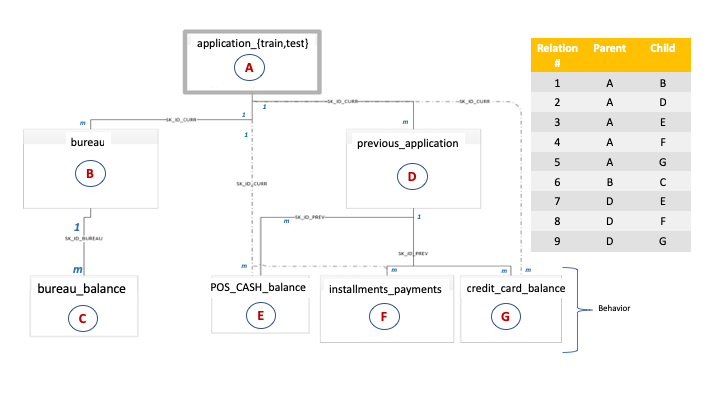

# Load

In [5]:
from quilt.data.avare import homecredit

# Validate Data Types

Featuretools, infers type using Pandas.

Sometimes, the inferred ones may not be what you expect. We could avoid this problem by including the types as an argument in the read_csv, but - we did not use read_csv() with Quilt.

To handle the mismatch, we perform a bit of housekeeping. We use this explicit mapping in later with featuretools.

In [10]:
# read metadata file , white space in the some colums ...bump...removed manually
description = pd.read_excel('data/HomeCredit_columns_description.xlsx', sheet_name='Sheet1',usecols=[2,3,4])
description.head()

,Table,Row,Type
0,application_train,SK_ID_CURR,categorical
1,application_train,TARGET,categorical
2,application_train,NAME_CONTRACT_TYPE,categorical
3,application_train,CODE_GENDER,categorical
4,application_train,FLAG_OWN_CAR,categorical


In [36]:
overlap_df = frames["application_train"].merge(frames["bureau"], on="SK_ID_CURR", how='inner')
skids = pd.unique(overlap_df['SK_ID_CURR'])
lst = skids.tolist()

In [37]:
import random 
random.seed(a=1)
asample = sample(lst, 100)
print(asample)

[195194, 144723, 280662, 183553, 451266, 418732, 434780, 369080, 248882, 166482, 445821, 120195, 376237, 406668, 101532, 415911, 288687, 262147, 172446, 325143, 121788, 115925, 118138, 106586, 370211, 253524, 398930, 120688, 257177, 410455, 451530, 265179, 345090, 263619, 255085, 425761, 305341, 115329, 394719, 170882, 231828, 310065, 185667, 335953, 455010, 398924, 234608, 315115, 301313, 454019, 378747, 124594, 440405, 272006, 386278, 393387, 222805, 360173, 365589, 161258, 411244, 176496, 216192, 378688, 362593, 447133, 121073, 432651, 130891, 318797, 378898, 220890, 219680, 456030, 260840, 108766, 241428, 264554, 386422, 343759, 350450, 425464, 290781, 104080, 372000, 191528, 245662, 401768, 139790, 441021, 358510, 241656, 392740, 443758, 352933, 393463, 345363, 101134, 334822, 424704]


In [38]:
# rename types in data description to python types
python_cat_dtype = 'object'
python_num_dtype = 'float64'
description.replace('categorical', python_cat_dtype, inplace=True)
description.replace('numerical', python_num_dtype, inplace=True)

merged = {}
frames = {}
lst = ['POS_CASH_balance','application_train','bureau','bureau_balance',
       'credit_card_balance',
       'installments_payments','previous_application']

for key in lst:
    
    print(key)
    
    df = homecredit[key]().copy(deep=True)
     
    if ( key == 'previous_application' ):
        dropcols = ['RATE_INTEREST_PRIVILEGED','RATE_INTEREST_PRIMARY']
        df.drop(dropcols, axis=1, inplace=True)
    
    # select types for the target cols
    types = description[(description.Table == key)]
    
    # select the target columns 
    targetcols = pd.DataFrame(df.columns, columns=['Row'])
    
    #print(targetcols)
    #print(types)
    
    # perform join:
    targetcols = targetcols.merge(types, how='left')

    #print(merged)
    
    # batch overide inferred categoricals 
    catcols = targetcols.loc[(targetcols.Type == python_cat_dtype),'Row'].values.tolist()
    df[catcols] = df[catcols].astype(python_cat_dtype)

    # batch overide inferred numericals
    numcols = targetcols.loc[(targetcols.Type == python_num_dtype),'Row'].values.tolist()
    df[numcols] = df[numcols].astype(python_num_dtype)

    frames[key] = df
    merged[key] = targetcols

POS_CASH_balance
application_train
bureau
bureau_balance
credit_card_balance
installments_payments
previous_application


# Merge and Subsample

ensure alignment among with primary key table contains target concept!

## EntitySet

[Entity Set](https://docs.featuretools.com/generated/featuretools.EntitySet.entity_from_dataframe.html#featuretools-entityset-entity-from-dataframe) represents a  set of database tables, as shown in the image above. 


In [39]:
# create an entity set
es = ft.EntitySet(id="homecredit_data")

## helper function :  create a dictionary feature tool types
def as_dict_featuretools(df):
    
    # df has two columns: Row(column name) Type (a python dtype)
    categorical = 'object'
    numeric = 'float64'

    # rename types
    df.replace(numeric, ft.variable_types.Numeric, inplace=True)
    df.replace(categorical, ft.variable_types.Categorical, inplace=True)

    # convert to dict
    tuples = dict([*zip(df.Row.values, df.Type.values)])
    return tuples

## (A) : Application Entity

In [ ]:

#x = homecredit["application_train"]()
# create a subset of the data
#x.loc[x["SK_ID_CURR"].isin(skids)]

In [42]:
table_name = 'application_train'
index = 'SK_ID_CURR'

variable_types = as_dict_featuretools(merged[table_name])

x = frames[table_name]
asubset = x.loc[x["SK_ID_CURR"].isin(asample)]

es = es.entity_from_dataframe(dataframe=asubset,
                              entity_id=table_name,
                              index=index,
                              variable_types = variable_types)

## (B) : Bureau  Entity

In [43]:
table_name = 'bureau'
index = 'SK_ID_BUREAU'

variable_types = as_dict_featuretools(merged[table_name])
 
x = frames[table_name]
asubset = x.loc[x["SK_ID_CURR"].isin(asample)]

es = es.entity_from_dataframe(dataframe=asubset,
                              entity_id=table_name,
                              index=index,
                              variable_types=variable_types)


In [44]:
es["bureau"].variables[0:20]

[<Variable: SK_ID_BUREAU (dtype = index)>,
 <Variable: SK_ID_CURR (dtype = categorical)>,
 <Variable: CREDIT_ACTIVE (dtype = categorical)>,
 <Variable: CREDIT_CURRENCY (dtype = categorical)>,
 <Variable: DAYS_CREDIT (dtype = numeric)>,
 <Variable: CREDIT_DAY_OVERDUE (dtype = numeric)>,
 <Variable: DAYS_CREDIT_ENDDATE (dtype = numeric)>,
 <Variable: DAYS_ENDDATE_FACT (dtype = numeric)>,
 <Variable: AMT_CREDIT_MAX_OVERDUE (dtype = numeric)>,
 <Variable: CNT_CREDIT_PROLONG (dtype = numeric)>,
 <Variable: AMT_CREDIT_SUM (dtype = numeric)>,
 <Variable: AMT_CREDIT_SUM_DEBT (dtype = numeric)>,
 <Variable: AMT_CREDIT_SUM_LIMIT (dtype = numeric)>,
 <Variable: AMT_CREDIT_SUM_OVERDUE (dtype = numeric)>,
 <Variable: CREDIT_TYPE (dtype = categorical)>,
 <Variable: DAYS_CREDIT_UPDATE (dtype = numeric)>,
 <Variable: AMT_ANNUITY (dtype = numeric)>]

## (C) : Bureau Balance Entity

In [157]:
frames['bureau_balance'].head()

,INDEX,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
4044793,0,5897855.0,-53.0,X
22812152,1,5992461.0,-83.0,0
25741451,2,6112224.0,-61.0,0
24716366,3,5552491.0,-61.0,X
899375,4,6591883.0,-29.0,C


In [119]:
table_name = 'bureau_balance'
index = 'INDEX'

variable_types = as_dict_featuretools(merged[table_name])
es = es.entity_from_dataframe(dataframe=frames[table_name],
                              entity_id=table_name,
                              index=index,
                              make_index=True,
                              variable_types=variable_types)

print(len(variable_types))

4


In [175]:
table_name = 'previous_application'
index = 'SK_ID_PREV'

variable_types = as_dict_featuretools(merged[table_name])
es = es.entity_from_dataframe(dataframe=frames[table_name],
                              entity_id=table_name,
                              index=index,
                              variable_types=variable_types)

print(len(variable_types))

35


# Relations

In [45]:
## Relation A-B
new_relationship = ft.Relationship(es["application_train"]["SK_ID_CURR"],
                                    es["bureau"]["SK_ID_CURR"])
es = es.add_relationship(new_relationship)

## Relation B-C
#new_relationship = ft.Relationship(es["bureau"]["SK_ID_BUREAU"],
#es["bureau_balance"]["INDEX"])
es

Entityset: homecredit_data
  Entities:
    application_train [Rows: 100, Columns: 122]
    bureau [Rows: 609, Columns: 17]
  Relationships:
    bureau.SK_ID_CURR -> application_train.SK_ID_CURR

In [46]:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity="application_train")

In [48]:
feature_matrix
#feature_matrix.loc[feature_matrix["SK_ID_CURR"].isin(asample)]

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,...,STD(bureau.CNT_CREDIT_PROLONG),STD(bureau.AMT_CREDIT_SUM),STD(bureau.AMT_CREDIT_SUM_DEBT),STD(bureau.AMT_CREDIT_SUM_LIMIT),STD(bureau.AMT_CREDIT_SUM_OVERDUE),STD(bureau.DAYS_CREDIT_UPDATE),STD(bureau.AMT_ANNUITY),MAX(bureau.DAYS_CREDIT),MAX(bureau.CREDIT_DAY_OVERDUE),MAX(bureau.DAYS_CREDIT_ENDDATE),MAX(bureau.DAYS_ENDDATE_FACT),MAX(bureau.AMT_CREDIT_MAX_OVERDUE),MAX(bureau.CNT_CREDIT_PROLONG),MAX(bureau.AMT_CREDIT_SUM),MAX(bureau.AMT_CREDIT_SUM_DEBT),MAX(bureau.AMT_CREDIT_SUM_LIMIT),MAX(bureau.AMT_CREDIT_SUM_OVERDUE),MAX(bureau.DAYS_CREDIT_UPDATE),MAX(bureau.AMT_ANNUITY),SKEW(bureau.DAYS_CREDIT),SKEW(bureau.CREDIT_DAY_OVERDUE),SKEW(bureau.DAYS_CREDIT_ENDDATE),SKEW(bureau.DAYS_ENDDATE_FACT),SKEW(bureau.AMT_CREDIT_MAX_OVERDUE),SKEW(bureau.CNT_CREDIT_PROLONG),SKEW(bureau.AMT_CREDIT_SUM),SKEW(bureau.AMT_CREDIT_SUM_DEBT),SKEW(bureau.AMT_CREDIT_SUM_LIMIT),SKEW(bureau.AMT_CREDIT_SUM_OVERDUE),SKEW(bureau.DAYS_CREDIT_UPDATE),SKEW(bureau.AMT_ANNUITY),MIN(bureau.DAYS_CREDIT),MIN(bureau.CREDIT_DAY_OVERDUE),MIN(bureau.DAYS_CREDIT_ENDDATE),MIN(bureau.DAYS_ENDDATE_FACT),MIN(bureau.AMT_CREDIT_MAX_OVERDUE),MIN(bureau.CNT_CREDIT_PROLONG),MIN(bureau.AMT_CREDIT_SUM),MIN(bureau.AMT_CREDIT_SUM_DEBT),MIN(bureau.AMT_CREDIT_SUM_LIMIT),MIN(bureau.AMT_CREDIT_SUM_OVERDUE),MIN(bureau.DAYS_CREDIT_UPDATE),MIN(bureau.AMT_ANNUITY),MEAN(bureau.DAYS_CREDIT),MEAN(bureau.CREDIT_DAY_OVERDUE),MEAN(bureau.DAYS_CREDIT_ENDDATE),MEAN(bureau.DAYS_ENDDATE_FACT),MEAN(bureau.AMT_CREDIT_MAX_OVERDUE),MEAN(bureau.CNT_CREDIT_PROLONG),MEAN(bureau.AMT_CREDIT_SUM),MEAN(bureau.AMT_CREDIT_SUM_DEBT),MEAN(bureau.AMT_CREDIT_SUM_LIMIT),MEAN(bureau.AMT_CREDIT_SUM_OVERDUE),MEAN(bureau.DAYS_CREDIT_UPDATE),MEAN(bureau.AMT_ANNUITY),COUNT(bureau),NUM_UNIQUE(bureau.CREDIT_ACTIVE),NUM_UNIQUE(bureau.CREDIT_CURRENCY),NUM_UNIQUE(bureau.CREDIT_TYPE),MODE(bureau.CREDIT_ACTIVE),MODE(bureau.CREDIT_CURRENCY),MODE(bureau.CREDIT_TYPE)
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101134,0,Cash loans,F,Y,N,0.0,135000.0,450000.0,23107.5,450000.0,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,0.004849,-15175.0,-3046.0,-3141.0,-3160.0,12.0,1,1,0,1,1,0,Managers,2.0,2,2,FRIDAY,16.0,0,0,0,0,1,1,Hotel,0.493555,0.410219,0.513694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.333333,1.505046e+05,150980.878492,0.000000,0.0,484.906721,12346.058156,-345.0,0.0,30983.0,-309.0,0.000,1.0,532192.500,398205.000,0.000,0.0,-4.0,21384.000,-0.460411,0.0,2.885833,-0.609373,NaN,3.0,0.603410,1.366175,0.000000,0.0,-1.077227,1.732051,-2440.0,0.0,-1435.0,-1435.0,0.000,0.0,29295.000,0.000,0.000,0.0,-1429.0,0.000,-1215.333333,0.0,3562.111111,-777.166667,0.000000,0.111111,2.273226e+05,98521.312500,0.000000,0.0,-453.555556,7128.000,9,2,1,2,Closed,currency 1,Consumer credit
101532,0,Cash loans,M,Y,Y,1.0,225000.0,1

In [28]:
feature_matrix.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 100145 to 456226
Data columns (total 199 columns):
NAME_CONTRACT_TYPE                     object
CODE_GENDER                            object
FLAG_OWN_CAR                           object
FLAG_OWN_REALTY                        object
CNT_CHILDREN                           float64
AMT_INCOME_TOTAL                       float64
AMT_CREDIT                             float64
AMT_ANNUITY                            float64
AMT_GOODS_PRICE                        float64
NAME_TYPE_SUITE                        object
NAME_INCOME_TYPE                       object
NAME_EDUCATION_TYPE                    object
NAME_FAMILY_STATUS                     object
NAME_HOUSING_TYPE                      object
REGION_POPULATION_RELATIVE             float64
DAYS_BIRTH                             float64
DAYS_EMPLOYED                          float64
DAYS_REGISTRATION                      float64
DAYS_ID_PUBLISH                        float64
O

Run time on all data:

CPU times: user 27min 32s, sys: 32.1 s, total: 28min 4s
Wall time: 29min 56s

Problem: must handle missing data in order for features to be computed!!

If we impute missing data for real numbers - we could introduce bias 

In [397]:
# reset
table_name = 'bureau_balance'
#frames[table_name].reset_index()
#frames[table_name].drop('INDEX', axis=1, inplace=True)
frames[table_name]

,INDEX,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,0,5715448,0,C
1,1,5715448,-1,C
2,2,5715448,-2,C
3,3,5715448,-3,C
4,4,5715448,-4,C
5,5,5715448,-5,C
6,6,5715448,-6,C
7,7,5715448,-7,C
8,8,5715448,-8,C
9,9,5715448,-9,0


In [393]:
# reset
table_name = 'bureau_balance'
homecredit[table_name]().reset_index()
homecredit[table_name]().drop('INDEX', axis=1, inplace=True)
homecredit[table_name]()

KeyError: "['INDEX'] not found in axis"

In [396]:
table_name = 'bureau_balance'
homecredit[table_name]()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [ ]:
data = ft.demo.load_mock_customer()
data['transactions'].head()

In [ ]:
# specify entities
entities = {
    "application_train" : (frames["application_train"], "SK_ID_CURR"),
    "bureau" : (frames["bureau"], "SK_ID_BUREAU") 
}
# specify relations
relationships = [("application_train", "SK_ID_CURR", "bureau", "SK_ID_CURR")]

# feature matrix
feature_matrix_customers, features_defs = ft.dfs(entities=entities,
                                                 relationships=relationships,
                                                 target_entity="application_train")

In [24]:
import featuretools as ft

data = ft.demo.load_mock_customer()

transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])


transactions_df['transaction_id'].sort_values()

63       1
1        2
484      3
154      4
305      5
485      6
347      7
276      8
27       9
9       10
222     11
120     12
178     13
486     14
76      15
298     16
431     17
270     18
348     19
147     20
34      21
97      22
226     23
449     24
238     25
183     26
58      27
90      28
10      29
115     30
      ... 
362    471
462    472
429    473
263    474
62     475
404    476
335    477
424    478
372    479
450    480
395    481
454    482
437    483
285    484
108    485
5      486
230    487
299    488
421    489
148    490
420    491
116    492
488    493
261    494
13     495
172    496
470    497
244    498
46     499
472    500
Name: transaction_id, Length: 500, dtype: int64